## Imports and settings

In [1]:
import sys
from pathlib import Path

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import genextreme

from mcmceva import stats, plot
from common import load_anduryl_project, load_directories

from adjustText import adjust_text

%matplotlib inline

In [2]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Verdana"
plt.rcParams["font.size"] = 8

plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.alpha"] = 0.40

plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["axes.titleweight"] = "bold"

plt.rcParams["legend.handletextpad"] = 0.4
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.labelspacing"] = 0.2
plt.rcParams["legend.fancybox"] = False

plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
    
plt.rcParams["axes.labelpad"] = 2.0
plt.rcParams["xtick.major.pad"] = 2
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.pad"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["xtick.minor.pad"] = 1
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.minor.pad"] = 1
plt.rcParams["ytick.minor.size"] = 1


In [3]:
np.seterr(all="warn")

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [4]:
directories = load_directories()

In [5]:
project = load_anduryl_project()

In [6]:
downstreams = ["Borgharen", "Roermond", "Gennep"]

In [7]:
locations = [
    "Franse Maas, Chooz",
    "Semois, Membre",
    "Lesse, Gendron",
    "Sambre, Salzinnes",
    "Ourthe, Tabreux",
    "Ambleve, Martinrive",
    "Vesdre, Chaudfontaine",
    "Geul, Meerssen",
    "Roer, Stah",
    "Niers, Goch",
]

In [8]:
# Load discharge measurements
afvoermetingen = pd.read_csv(directories["meuse_measurements"] / "discharge_measurements.csv", index_col=[0])
afvoermetingen.index = pd.to_datetime(afvoermetingen.index)

# Get annual maxima
am_borgharen = stats.get_annual_maxima(
    afvoermetingen["Maas, Borgharen"] + np.linspace(0, 1e-3, len(afvoermetingen))
)

# Get annual maxima
ams = {
    loc: stats.get_annual_maxima(column + np.linspace(0, 1e-3, len(column)))
    for loc, column in afvoermetingen.iteritems()
}

ams["Borgharen"] = ams["Maas, Borgharen"]
ams["Roermond"] = ams["Maas, Venlo"]
ams["Gennep"] = ams["Maas, Venlo"]

## Common functions

In [9]:
def get_fig_ax(ymax):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel("Overschrijdingskans")
    ax.set_xlim(1, 1e-4)
    ax.set_xscale("log")
    ax.grid()  # which="both")
    ax.set_ylim(0, ymax * 1.5)
    ax.set_ylabel(f"Maximale jaarafvoer [m$^3$/s]")
    return fig, ax

In [10]:
def integrate_trace(trace, qrange):
    gev = genextreme(loc=np.ravel(trace["loc"]), scale=np.ravel(trace["scale"]), c=np.ravel(trace["c"]))
    exc_prob = 1 - gev.cdf(qrange[:, None]).mean(axis=1)
    return exc_prob

In [11]:
def plot_expert_estimates_pdf(ax, location, expert, return_period: list):

    # Plot the expert estimates
    for rp in return_period:

        item = f"{location.split(',')[1].strip()}T{rp}"
        estimates = project.assessments.estimates[expert][item].estimates

        expname = expert if expert in project.results else "GL"
        plotdata = project.results[expname].get_plot_data(experts=[expert], items=[item])[(item, expert)]

        # Don't plot the outer edges, assign a minimum required probability density for plotting
        min_edge_pd = 1e-5
        idx = np.where(plotdata.pdf_y > min_edge_pd)[0]
        idx = np.arange(idx[0], idx[-1], 1)

        x = np.interp(np.exp(plotdata.pdf_y[idx]), np.exp([0, plotdata.pdf_y.max()]), [1 / rp, 0.2 / rp])
        ax.plot(x, plotdata.pdf_x[idx], color="k", lw=0.75)
        ax.plot([1 / rp, 1 / rp], [plotdata.pdf_x[idx.max()], plotdata.pdf_x[idx.min()]], color="k", lw=0.4)
        ax.plot(
            [1 / rp] * len(plotdata.estimates), list(plotdata.estimates.values()), color="k", marker="x", ls="", ms=3
        )

    return plotdata

In [12]:
def get_fig_axs(ncols, nrows, supercols, pairpos, vpart=1.0):
    fig = plt.figure(figsize=(22 / 2.54, 30 / 2.54))
    axs = []

    _pairpos = pairpos.copy()

    for irow in reversed(range(nrows)):
        for icol in range(supercols):

            pairpos = _pairpos.copy()
            pairpos[:, :, 0] = pairpos[:, :, 0] * (1 / supercols)
            pairpos[:, 0, 0] = pairpos[:, 0, 0] + (1 / supercols) * icol
            pairpos[:, :, 1] = pairpos[:, :, 1] * (vpart / nrows)
            pairpos[:, 0, 1] = pairpos[:, 0, 1] + (vpart / nrows) * irow

            for pos in pairpos:
                ax = fig.add_axes(pos.ravel())
                axs.append(ax)

    axs = np.reshape(axs, (nrows, ncols))

    return fig, axs

## Plot tributary curves

In [13]:
textpos = {}

### For expert estimates and combination

In [14]:
modes = ["ej", "both"]
colors = ["C1", "C3"]
annotations = ["EJ only", "Combined"]

supercols = 2
ncols = 4
nrows = 5

exc_probs = np.logspace(np.log10(0.99e0), np.log10(1e-4), 50, base=10)

longname = {
    exp: exp.replace("Exp", "Expert ")
    .replace("GL", "Global weights Decision Maker")
    .replace("EQ", "Equal weights Decision Maker")
    for exp in project.experts.ids
}

0.001


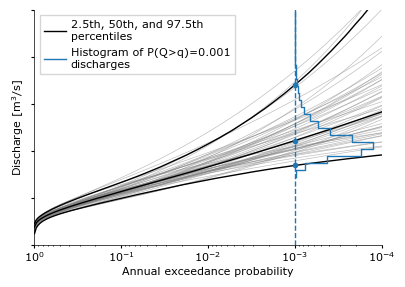

In [15]:
dm  = project.experts.ids[6]

fig, ax = plt.subplots(figsize=(10/2.54, 7/2.54), constrained_layout=True)

location = locations[0]

mode = modes[1]

file = directories["sampledir"] / f"{location}_{mode}{'' if mode == 'obs' else '_'+dm}.pkl"

with open(file, 'rb') as f:
    trace = pickle.load(f)
    
exc_probs_tmp = np.logspace(np.log10(0.99e0), np.log10(1e-4), 200, base=10)
    
np.random.seed(1)
for _ in range(50):
    i = np.random.randint(low=0, high=len(trace['loc'])-1)
    iloc, ic, iscale = trace['loc'][i], trace['c'][i], trace['scale'][i]
    gev = genextreme(loc=iloc, scale=iscale, c=ic)
    if gev.pdf(3000) == 0:
        continue
    q = gev.ppf(1 - exc_probs_tmp)
    ax.plot(exc_probs_tmp, q, color='grey', lw=0.5, alpha=0.5, label='50 of the 10,000 Individual\nGEV-realizations/curves' if i == 0 else '')

data = plot.calc_percentiles(
    trace, dist=genextreme, pps=3, exc_probs=exc_probs_tmp
)

for i, row in enumerate(data.T):
    ax.plot(exc_probs_tmp, row, color='k',lw=1, label='2.5th, 50th, and 97.5th\npercentiles' if i == 0 else None)

def transform(p, x):
        return np.log((np.exp(p) - x * 800 * p) )

for p, color in zip([0.001], ['C0']):
    print(p)
    discharges = genextreme(**trace).ppf(1 - p)
    count, edges = np.histogram(discharges, density=True, bins=33)
    ax.plot(transform(p, np.r_[count, count[-1]]), edges, drawstyle='steps-pre', color=color, lw=1, label=f'Histogram of P(Q>q)={p}\ndischarges')
    ax.axvline(p, color=color, ls='--', lw=1)
    ax.plot([p] * 3, np.percentile(discharges, [2.5, 50, 97.5]), marker='.', color=color, ls='')
    
    

       
ax.set(
    xscale='log',
    xlim=(1, 1e-4),
    ylim=(0, 5000),
    yticklabels=[],
    ylabel='Discharge [m$^3$/s]',
    xlabel='Annual exceedance probability'
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(loc='upper left', labelspacing=.6)

# fig.savefig(directories["figuredir"] / f"Curves_and_percentiles.pdf", bbox_inches='tight', pad_inches=0.01)

C:\Python\envs\pymc\lib\site-packages\scipy\stats\_continuous_distns.py:2750: RuntimeWarning: underflow encountered in exp
  return np.exp(self._logpdf(x, c))
C:\Python\envs\pymc\lib\site-packages\scipy\stats\_distn_infrastructure.py:2094: RuntimeWarning: underflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)


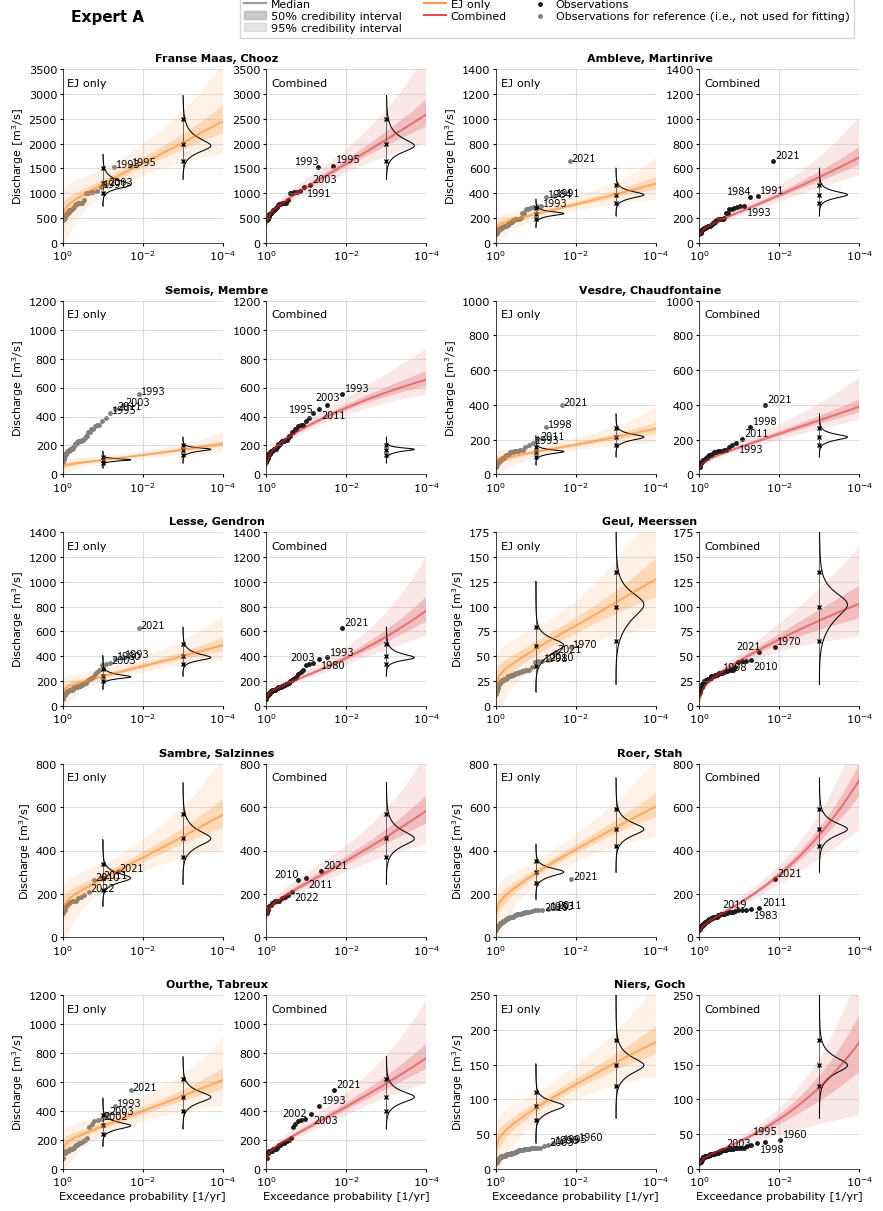

In [16]:
for dm in project.experts.ids:
    
#     if 'D' not in dm:
#         continue

    vpart = 0.98
    pairpos = np.array([[[0.12, 0.15], [0.37, 0.75]], [[0.59, 0.15], [0.37, 0.75]]])
    fig, axs = get_fig_axs(ncols, nrows, supercols, pairpos, vpart=vpart)

    for i, location in enumerate(locations):

        for j, (mode, color, annotation) in enumerate(zip(modes, colors, annotations)):

            irow = i % 5
            icol = j + (i // 5) * 2

            ax = axs[irow, icol]

            file = directories["sampledir"] / f"{location}_{mode}{'' if mode == 'obs' else '_'+dm}.pkl"
            if not file.exists():
                continue
                
            with open(file, 'rb') as f:
                trace = pickle.load(f)
#             if 'shape' in trace:
#                 with open(file, 'wb') as f:
#                     trace['c'] = trace['shape']
#                     del trace['shape']
#                     pickle.dump(trace, f)    

            valid = genextreme(**trace).pdf(ams[location].mean()) > 0.0
            trace = {key: np.array(values)[valid] for key, values in trace.items()}
            
            data = plot.calc_percentiles(
                trace, dist=genextreme, pps=5, exc_probs=exc_probs
            )

            if mode != "obs":
                plotdata = plot_expert_estimates_pdf(
                    ax, location, dm, return_period=[10, 1000] if mode == "ej" else [1000]
                )

            ymax = max(ams[location].max() * 2, plotdata.estimates[0.95] * 1.25)

            ax.set(
                xscale="log",
                ylim=(0, ymax),
                xlabel="Exceedance probability [1/yr]" if i % 5 == 4 else "",
                xlim=(1, 0.0001),
                ylabel=f"Discharge [m$^3$/s]" if j == 0 else "",
            )

            yticks = ax.get_yticks()
            ax.set(ylim=(0, max(yticks)), yticks=yticks)

            #         if j == 1:
            #             ax.set_yticklabels([])

            ax.annotate(
                annotation,
                (0.03, 0.95),
                fontweight="normal",
                fontsize=8,
                xycoords="axes fraction",
                va="top",
                ha="left",
            )

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            ax.grid()

            ams_loc = ams[location].sort_values(ascending=False)
            texts = plot.add_observations(
                ax,
                ams_loc,
                4 if location not in textpos else 0,
                plot_params=dict(s=25, color="0.5" if mode == "ej" else "0.1", label=None),
            )
            if mode != "ej":
                if location not in textpos:
                    adjust_text(texts, ax=ax)
                    # Save positions so that they only need to be determines once
                    textpos[location] = [
                        {
                            "x": t.get_position()[0],
                            "y": t.get_position()[1],
                            "ha": t.get_ha(),
                            "va": t.get_va(),
                        }
                        for t in texts
                    ]
                else:
                    for m, pos in zip(ams_loc.index.year[:4], textpos[location]):
                        ax.text(s=m, **pos, fontsize=7)

            plot.plot_percentiles_filled(ax, exc_probs, data, color=color, label=False)

            #             # Add title above two axes
            if j == 0:
                pos = (0.25 + icol * 0.25, (1 - irow * 0.2) * vpart)
                ax.annotate(
                    text=location,
                    xy=pos,
                    xycoords="figure fraction",
                    va="top",
                    ha="center",
                    zorder=10,
                    fontsize=8,
                    fontweight="bold",
                )
                
    # Legend
    ax = axs[0, -1]
    ax.plot([], [], color='grey', alpha=0.8, label='Median')
    ax.fill([], [], color='grey', alpha=0.4, label="50% credibility interval")
    ax.fill([], [], color='grey', alpha=0.2, label="95% credibility interval")

    ax.plot([], [], color='C1', alpha=0.8, label=annotations[0])
    ax.plot([], [], color='C3', alpha=0.8, label=annotations[1])
#     ax.plot([], [], color='C3', alpha=0.8, label=annotations[2])

    ax.scatter([], [], marker=".", **dict(s=25, label="Observations", color="0.1"))
    ax.scatter([], [], marker=".", **dict(s=25, label="Observations for reference (i.e., not used for fitting)", color="0.5"))

    leg = ax.legend(bbox_to_anchor=(1, 1.15), ncol=3, loc='lower right')
    leg.set_in_layout(False)


    fig.suptitle(longname[dm].replace('Decision', '\nDecision'), fontsize=11, fontweight="bold", y=1.005, va="center", ha='left', x=0.07)
#     fig.savefig(directories["figuredir"] / f"ej_comb_curves_{dm}.pdf", bbox_extra_artists=(leg,), bbox_inches='tight', pad_inches=0.01)
#     plt.close(fig)

    break

In [17]:
# df = ams['Lesse, Gendron'].copy()
# df.index = df.index.year
# df.to_clipboard()

### For observations

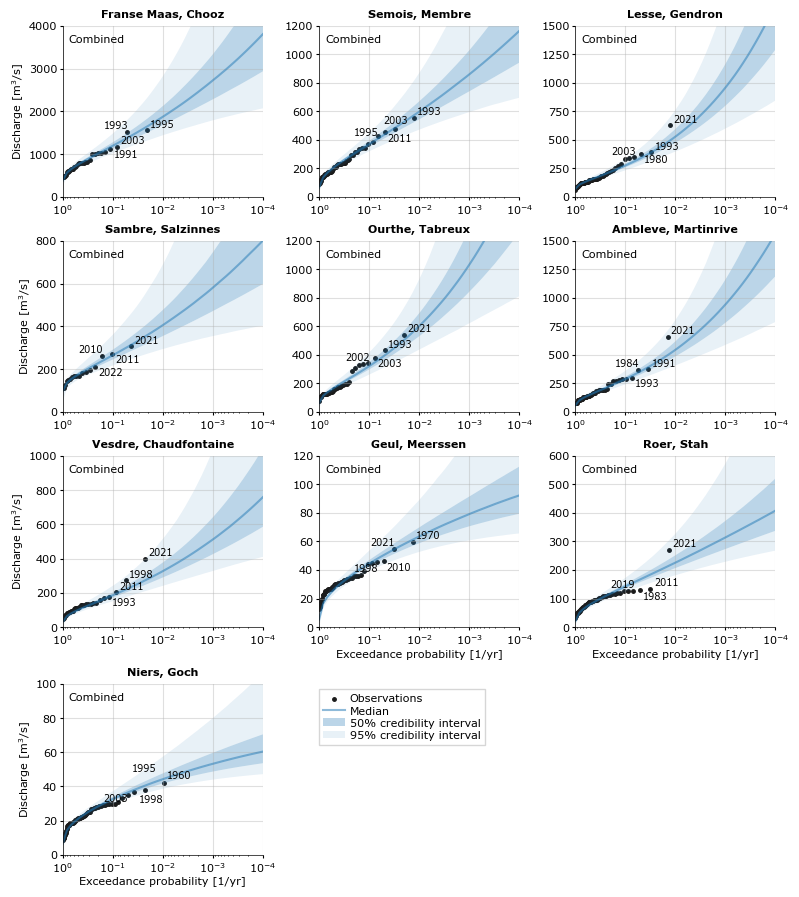

In [18]:
vpart = 1.0
fig, axs = plt.subplots(figsize=(20 / 2.54, 30 / 2.54 * 0.75), ncols=3, nrows=4, constrained_layout=True)

for i, location in enumerate(locations):

    mode = "obs"
    color = "C0"

    ax = axs.ravel()[i]

    file = directories["sampledir"] / f"{location}_{mode}{'' if mode == 'obs' else '_'+dm}.pkl"
    if not file.exists():
        continue
    with open(file, 'rb') as f:
        trace = pickle.load(f)
            
    valid = genextreme(**trace).pdf(50) > 0.0
    trace = {key: np.array(values)[valid] for key, values in trace.items()}

    data = plot.calc_percentiles(trace, dist=genextreme, pps=5, exc_probs=exc_probs)

    ymax = ams[location].max() * 2

    ax.set(
        xscale="log",
        ylim=(0, ymax),
        xlabel="Exceedance probability [1/yr]" if i > 6 else "",
        xlim=(1, 0.0001),
        ylabel=f"Discharge [m$^3$/s]" if i % 3 == 0 else "",
        title=location,
    )

    yticks = ax.get_yticks()
    ax.set(ylim=(0, max(yticks)), yticks=yticks)

    #         if j == 1:
    #             ax.set_yticklabels([])

    ax.annotate(
        annotation,
        (0.03, 0.95),
        fontweight="normal",
        fontsize=8,
        xycoords="axes fraction",
        va="top",
        ha="left",
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid()

    if mode != "ej":
        ams_loc = ams[location].sort_values(ascending=False)
        texts = plot.add_observations(
            ax,
            ams_loc,
            4 if location not in textpos else 0,
            plot_params=dict(s=25, label="Observations", color="0.5" if mode == "ej" else "0.1"),
        )
        if location not in textpos:
            adjust_text(texts, ax=ax)
            # Save positions so that they only need to be determines once
            textpos[location] = [
                {
                    "x": t.get_position()[0],
                    "y": t.get_position()[1],
                    "ha": t.get_ha(),
                    "va": t.get_va(),
                }
                for t in texts
            ]
        else:
            for m, pos in zip(ams_loc.index.year[:4], textpos[location]):
                ax.text(s=m, **pos, fontsize=7)

    plot.plot_percentiles_filled(ax, exc_probs, data, color=color)
    
for i in range(i + 1, 12):
    fig.delaxes(axs.ravel()[i])

leg = ax.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
leg.set_in_layout(False)
    
# fig.savefig(directories["figuredir"] / f"obs_curves.pdf", bbox_inches='tight', pad_inches=0.01)
# plt.close(fig)

## Plot downstream curves

In [19]:
Nevents = 10000

all_exc_probs = stats.convert_freq_prob(1.0 / stats.calc_return_period_am(np.arange(Nevents)))
int_exc_prob = np.sort(
    np.concatenate(
        [
            [0.1, 0.01, 0.001],
            np.logspace(np.log10(all_exc_probs[0]), np.log10(all_exc_probs[-1]), 200, base=10),
        ]
    )
)[::-1]
# Find nearest
idx = np.unique([np.argmin(np.absolute(all_exc_probs - ep)) for ep in int_exc_prob])
exc_probs = all_exc_probs[idx]

modes = ["ej", "both"]
colors = ["C1", "C3"]
annotations = ["EJ only", "Combined"]

In [20]:
def format_axis(ax, ymax, annotation, xlabel, ylabel):
    ax.set(
        xscale="log",
        ylim=(0, ymax),
        xlabel=xlabel,
        xlim=(1, 0.0001),
        ylabel=ylabel,
        xticks=[1, 0.1, 0.01, 0.001, 0.0001],
    )

    yticks = ax.get_yticks()
    ax.set(ylim=(0, max(yticks)), yticks=yticks)

    ax.annotate(
        annotation,
        (0.03, 0.95),
        fontweight="normal",
        fontsize=8,
        xycoords="axes fraction",
        va="top",
        ha="left",
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid()


def add_annual_maxima(ax, location, color='0.1', label="Observations", add_labels=True):
    ams_loc = ams[location].sort_values(ascending=False)
    texts = plot.add_observations(
        ax,
        ams_loc,
        4 if location not in textpos else 0,
        plot_params=dict(s=25, label=label, color=color),
    )
    if add_labels:
        if location not in textpos:
            adjust_text(texts, ax=ax)
            # Save positions so that they only need to be determines once
            textpos[location] = [
                {
                    "x": t.get_position()[0],
                    "y": t.get_position()[1],
                    "ha": t.get_ha(),
                    "va": t.get_va(),
                }
                for t in texts
            ]
        else:
            for m, pos in zip(ams_loc.index.year[:4], textpos[location]):
                ax.text(s=m, **pos, fontsize=7)


def add_title(ax, title, icol, irow, vpart):
    pos = (0.25 + icol * 0.25, (1 - irow * 0.2) * vpart)
    ax.annotate(
        text=title,
        xy=pos,
        xycoords="figure fraction",
        va="top",
        ha="center",
        zorder=10,
        fontsize=8,
        fontweight="bold",
    )

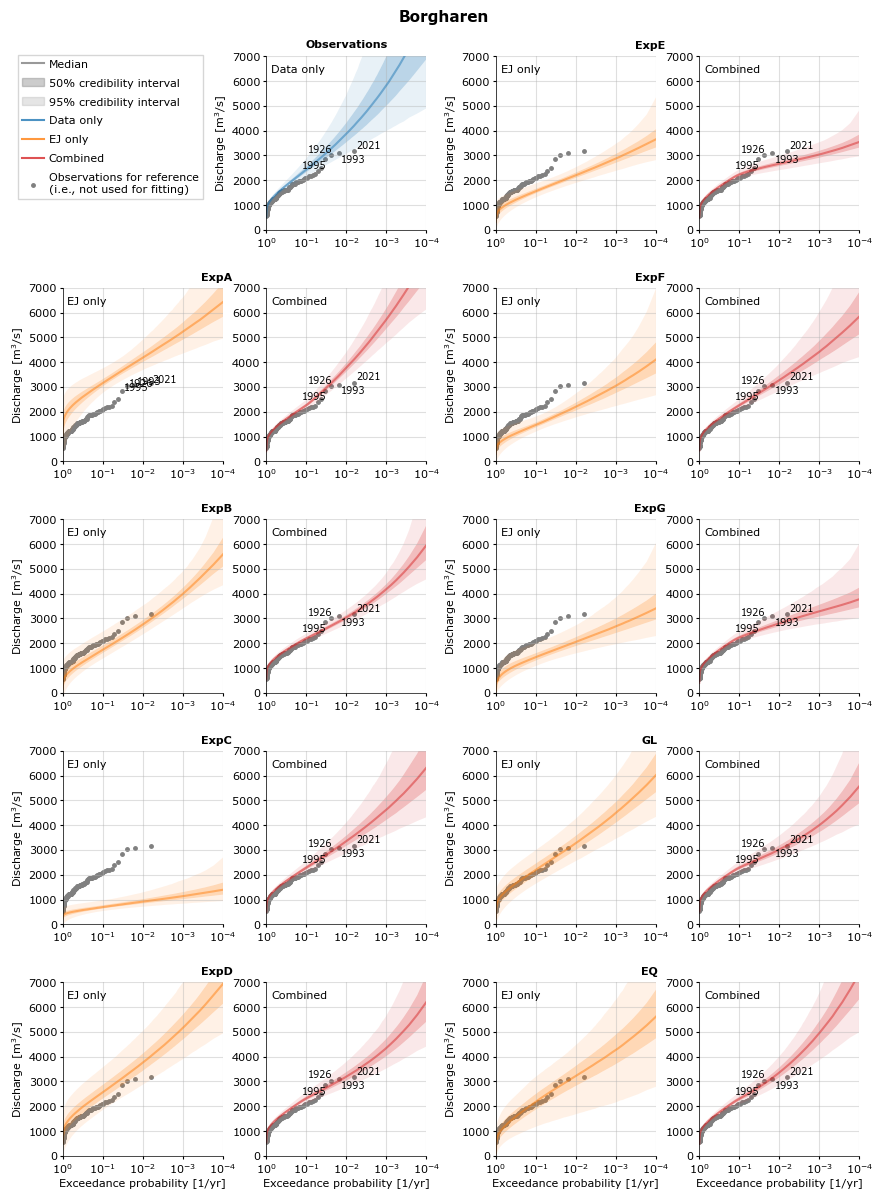

In [21]:
percentiles = np.array([2.5, 25.0, 50.0, 75.0, 97.5])

for location in downstreams:

    vpart = 0.98
    pairpos = np.array([[[0.12, 0.15], [0.37, 0.75]], [[0.59, 0.15], [0.37, 0.75]]])
    fig, axs = get_fig_axs(ncols, nrows, supercols, pairpos, vpart=vpart)

    for i, expert in enumerate(project.experts.ids):

        i += 1

        for j, (mode, color, annotation) in enumerate(zip(modes, colors, annotations)):

            irow = i % 5
            icol = j + (i // 5) * 2

            ax = axs[irow, icol]

            data = pd.read_csv(
                directories["sampledir"]
                / location
                / f"{location}_{mode}{'' if mode == 'obs' else '_'+expert}.csv",
                index_col=[0],
            )
            exc_probs = data.index.to_numpy()
            data = data.loc[:, percentiles.astype(str)].to_numpy()

            format_axis(
                ax=ax,
                ymax=7000,
                annotation=annotation,
                xlabel="Exceedance probability [1/yr]" if i % 5 == 4 else "",
                ylabel=f"Discharge [m$^3$/s]" if j == 0 else "",
            )

#             if mode != "ej":
            add_annual_maxima(ax, location, color="0.5", add_labels=mode!='ej')

            plot.plot_percentiles_filled(ax, exc_probs, data, color=color, label=False)

            #             # Add title above two axes
            if j == 0:
                add_title(ax, expert, icol, irow, vpart)

    # Add plot for observations only
    ax = axs[0, 1]
    mode = "obs"
    color = "C0"
    annotation = "Data only"

    data = pd.read_csv(
        directories["sampledir"] / location / f"{location}_{mode}{'' if mode == 'obs' else '_'+expert}.csv",
        index_col=[0],
        usecols=[0, 1, 3, 4, 5, 7],
    ).to_numpy()

    format_axis(ax=ax, ymax=7000, annotation=annotation, xlabel="", ylabel="Discharge [m$^3$/s]")

    add_annual_maxima(ax, location, label=None, color='0.5')

    plot.plot_percentiles_filled(ax, exc_probs, data, color=color, label=False)

    axs[0, 1].set_title("Observations")
    
    
    ax = axs[0, 1]
    ax.plot([], [], color='grey', alpha=0.8, label='Median')
    ax.fill([], [], color='grey', alpha=0.4, label="50% credibility interval")
    ax.fill([], [], color='grey', alpha=0.2, label="95% credibility interval")

    ax.plot([], [], color='C0', alpha=0.8, label='Data only')
    ax.plot([], [], color='C1', alpha=0.8, label='EJ only')
    ax.plot([], [], color='C3', alpha=0.8, label='Combined')

#     ax.scatter([], [], marker=".", **dict(s=25, label="Observations", color="0.1"))
    ax.scatter([], [], marker=".", **dict(s=25, label="Observations for reference\n(i.e., not used for fitting)", color="0.5"))

    leg = ax.legend(bbox_to_anchor=(-0.36, 1.04), loc='upper right', labelspacing=.8)
    leg.set_in_layout(False)


    fig.delaxes(axs[0, 0])

    fig.suptitle(location, fontsize=11, fontweight="bold", y=1.0, va="top")
#     fig.savefig(directories["figuredir"] / f"downstream_curves_{location}.pdf", bbox_inches='tight', pad_inches=0.01)
    
#     plt.close(fig)
    break